In [3]:
import pandas as pd
import numpy as np
import scipy
import itertools
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, confusion_matrix, plot_roc_curve, accuracy_score

# Data Prep.:

In [4]:
data = pd.read_csv('/Users/belleshen/Documents/VS_Code/Project/AirPressureSystemFailureDetection/Data/archive/aps_failure_training_set.csv')

# replace 'na' with -1
data = data.applymap(lambda x: -1 if x == 'na' else x)

# replace target feature with numerical numbers:
data['class'] = data['class'].map(lambda x: 1 if x == 'pos' else 0)

# turn all the features into numerical in order to get correlation coefficient
for i in data.columns:
    data[i] = pd.to_numeric(data[i])

# get feature importance:

feature_importance_df = pd.read_csv('feature_importance_df.csv')
feature_importance_df_sort = feature_importance_df.sort_values(by = 'feature_importance', ascending=False)

# define categorical df:

data_nunique_df = pd.DataFrame(data.nunique(), columns= ['nunique_values'])
data_cat_df = data_nunique_df[data_nunique_df.nunique_values < 100]

# define cat_cols & nu_cols:

cat_cols = list(set(feature_importance_df_sort.head(65)['columns']) & set(data_cat_df.index))
nu_cols = list(set(feature_importance_df_sort.head(65)['columns']) - set(data_cat_df.index))
data_nu_corr_matrix = data[nu_cols].corr()

# find high colinearity columns:

high_colinearity = []

for i in data_nu_corr_matrix.columns:
    a_series = data_nu_corr_matrix[i].sort_values(ascending=False)
    idx = list(a_series[a_series > .9].index)
    high_colinearity.append(idx)

print(f"high_colinearity length: {len(high_colinearity)}")

no_colinearity = [i for i in high_colinearity if len(i) == 1]

# remove the no-colinearity columns from the high_colinearity list:

for i in no_colinearity:
    if i in high_colinearity:
        high_colinearity.remove(i)

print(f"high_colinearity length: {len(high_colinearity)}, no_colinearity length:{len(no_colinearity)}")

# Find p-values of these high colinearity columns by doing linear regression of them:

scaler = MinMaxScaler()
scaler.fit(data[nu_cols])
data_scaled_nu = pd.DataFrame(scaler.transform(data[nu_cols]), columns = nu_cols)

def dimension_reduced():

    pvalues_box = []
    for i in high_colinearity:
        model = sm.OLS(data['class'], data_scaled_nu[i])
        res = model.fit()
        pvalues_box.append(res.pvalues)
    return pvalues_box

pvalues = dimension_reduced()

# find the minimum of pvalues of each high colinearity combination:

pvalues_df = pd.concat(pvalues, axis = 1)

candidate_cols_nonzero = []
candidate_cols_zero = []

for i in range(len(pvalues_df)):
    if pvalues_df.iloc[:, i].dropna().min() != 0:
        nonzero_col = pvalues_df.iloc[:, i].dropna().idxmin()
        candidate_cols_nonzero.append(nonzero_col)
    else:
        zero_col = sorted(pvalues_df.iloc[:, i].dropna()[pvalues_df.iloc[:, i].dropna() == 0].index.to_list()) 
        candidate_cols_zero.append(zero_col[0]) # select the first element in an alphabetically sorted list

candidate_cols = candidate_cols_nonzero.copy()
for i in candidate_cols_zero:
    candidate_cols.append(i)

print(f"candidate_cols length (before): {len(candidate_cols)}")

for i in no_colinearity:
    for j in i:
        candidate_cols.append(j)

print(f"candidate_cols length (after): {len(candidate_cols)}, candidate_cols length (w/o duplicates): {len(set(candidate_cols))}")

# define cols:

candidate_cols_new = list(set(candidate_cols))
main_cols          = cat_cols + candidate_cols_new 

print(f"candidate_cols_new length: {len(candidate_cols_new)}, main_cols length: {len(main_cols)}")


high_colinearity length: 64
high_colinearity length: 40, no_colinearity length:24
candidate_cols length (before): 40
candidate_cols length (after): 64, candidate_cols length (w/o duplicates): 39
candidate_cols_new length: 39, main_cols length: 40


In [9]:
data['class'].value_counts()[1]

1000

In [106]:
data['class'].value_counts()[0]/data['class'].value_counts()[1]

59.0

# Hyper parameters tuning for XGBoost classifier with more n_estimator and pos scaled weight (this time, I wont use SMOTENC)

/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f5eb13880>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f12694a60>)

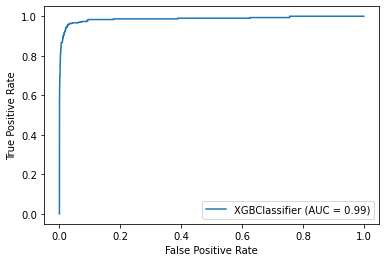

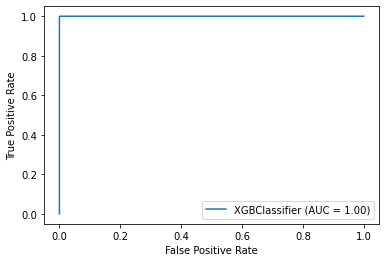

In [10]:
# train & test split:

x_train, x_test, y_train, y_test = train_test_split(data[main_cols], data[['class']], test_size = .3 ,random_state = 42, stratify = data['class'])

# # balance the train dataset:

# smt_1           = SMOTENC(random_state=42, categorical_features= list(range(len(cat_cols))))
# x_res, y_res    = smt_1.fit_resample(x_train, y_train)

# independent features & dependent feature combine:

train_combined_xgb = x_train.merge(y_train, how = 'left', right_index = True, left_index = True)
test_combined_xgb  = x_test.merge(y_test, how = 'left', right_index = True, left_index = True)

# feature engineering:

train_combined_xgb['aq_000 + ag_003'] = train_combined_xgb.apply(lambda x: x['aq_000'] + x['ag_003'] ,axis = 1)
train_combined_xgb['ci_000 + cj_000'] = train_combined_xgb.apply(lambda x: x['ci_000'] + x['cj_000'] ,axis = 1)

test_combined_xgb['aq_000 + ag_003']  = test_combined_xgb.apply(lambda x: x['aq_000'] + x['ag_003'] ,axis = 1)
test_combined_xgb['ci_000 + cj_000']  = test_combined_xgb.apply(lambda x: x['ci_000'] + x['cj_000'] ,axis = 1)

train_combined_xgb.drop(['aq_000', 'ag_003', 'ci_000', 'cj_000'], axis = 1, inplace = True)
test_combined_xgb.drop(['aq_000', 'ag_003', 'ci_000', 'cj_000'], axis = 1, inplace = True)

# one hot encoding:

train_dummies_xgb = pd.get_dummies(train_combined_xgb, columns = cat_cols)
test_dummies_xgb  = pd.get_dummies(test_combined_xgb, columns = cat_cols)

test_dummies_xgb  = test_dummies_xgb.reindex(columns = train_dummies_xgb.columns, fill_value = 0)
test_dummies_xgb  = test_dummies_xgb[train_dummies_xgb.columns]


# modeling:

model_xgb_3 = xgb.XGBClassifier(random_state = 42, learning_rate = .3, max_depth = 9, colsample_bytree = 0.7, gamma = 0.0, min_child_weight = 3, scale_pos_weight = data['class'].value_counts()[0]/data['class'].value_counts()[1])
model_xgb_3.fit(train_dummies_xgb.drop(['class'], axis = 1), train_dummies_xgb['class'])

plot_roc_curve(model_xgb_3, test_dummies_xgb.drop(['class'], axis = 1), test_dummies_xgb['class']), plot_roc_curve(model_xgb_3, train_dummies_xgb.drop(['class'], axis = 1), train_dummies_xgb['class'])

In [11]:
model_xgb_3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=59.0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
data['class'].value_counts()[0]/data['class'].value_counts()[1]

59.0

In [14]:
list(range(55, 59))

[55, 56, 57, 58]

In [15]:
def xgb_params_tuning():

    xgb_params = { "learning_rate"    : [0.30] ,
                   "max_depth"        : [9],
                   "min_child_weight" : [3],
                   "gamma"            : [ 0.0],
                   "colsample_bytree" : [0.7],
                   "n_estimators"     : list(range(100, 1000, 100)),
                   "scale_pos_weight" : list(range(55, 59))
                  }
                  
    grid_search = GridSearchCV(estimator= model_xgb_3, param_grid = xgb_params, scoring = 'precision', n_jobs = -1, cv = 5)
    grid_result = grid_search.fit(train_dummies_xgb.drop(['class'], axis = 1), train_dummies_xgb['class'])
    print(grid_result.best_score_, grid_result.best_params_)
    return grid_result

xgb_grid_result = xgb_params_tuning()

/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7949081009319974 {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 900, 'scale_pos_weight': 56}


In [16]:
cvres_xgb = xgb_grid_result.cv_results_
for mean_score, params in zip(cvres_xgb['mean_test_score'], cvres_xgb['params']):
    print(mean_score, params)

0.7610203033543386 {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 55}
0.7622228271319483 {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 56}
0.7580341575635693 {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 57}
0.7623600175615891 {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 58}
0.7697092644753174 {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 55}
0.7807667188844369 {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 56}
0.77253640

In [18]:
cvres_xgb['mean_test_score']

array([0.7610203 , 0.76222283, 0.75803416, 0.76236002, 0.76970926,
       0.78076672, 0.7725364 , 0.77674747, 0.77967629, 0.78290855,
       0.77814157, 0.78574437, 0.77654066, 0.78840179, 0.77833893,
       0.78213525, 0.77919874, 0.78880934, 0.78490181, 0.78702158,
       0.78109709, 0.79166333, 0.78166443, 0.78480235, 0.7835902 ,
       0.79328158, 0.78159433, 0.78618641, 0.78453316, 0.79295525,
       0.78121599, 0.79013327, 0.78418863, 0.7949081 , 0.7789074 ,
       0.79109555])

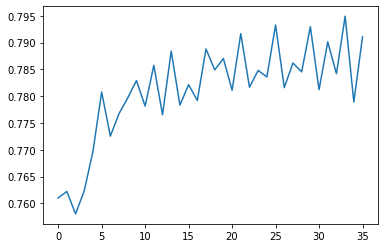

In [19]:
plt.plot(cvres_xgb['mean_test_score'])

# train XGBoost Classifier with best hyperparameters:

/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f4db79040>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f4db79100>)

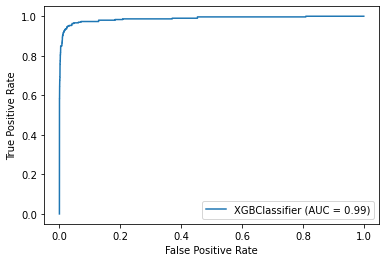

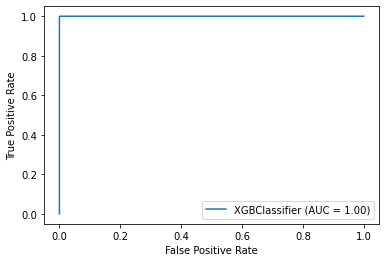

In [20]:
# modeling:

model_xgb_4 = xgb.XGBClassifier(random_state = 42, learning_rate = .3, max_depth = 9, colsample_bytree = 0.7, gamma = 0.0, min_child_weight = 3, scale_pos_weight = 56, n_estimators = 900)
model_xgb_4.fit(train_dummies_xgb.drop(['class'], axis = 1), train_dummies_xgb['class'])

plot_roc_curve(model_xgb_4, test_dummies_xgb.drop(['class'], axis = 1), test_dummies_xgb['class']), plot_roc_curve(model_xgb_4, train_dummies_xgb.drop(['class'], axis = 1), train_dummies_xgb['class'])

In [21]:
pred_xgb = model_xgb_4.predict(test_dummies_xgb.drop(['class'], axis = 1))
pred_xgb_prob = model_xgb_4.predict_proba(test_dummies_xgb.drop(['class'], axis = 1))

print(f"accuracy score: {accuracy_score(test_dummies_xgb['class'], pred_xgb)}")
print(f"precision score: {precision_score(test_dummies_xgb['class'], pred_xgb)}, recall score: {recall_score(test_dummies_xgb['class'], pred_xgb)}")
print(confusion_matrix(test_dummies_xgb['class'], pred_xgb))

accuracy score: 0.9931666666666666
precision score: 0.7791798107255521, recall score: 0.8233333333333334
[[17630    70]
 [   53   247]]


# Logistic:

(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f58b84df0>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f5eb1d160>)

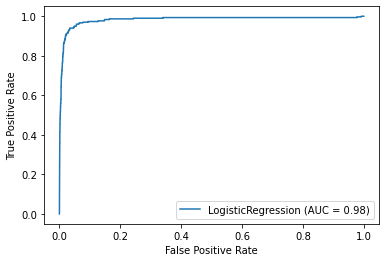

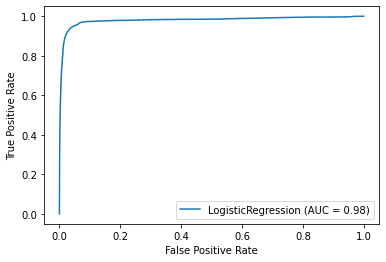

In [22]:
# train & test split:

x_train, x_test, y_train, y_test = train_test_split(data[main_cols], data[['class']], test_size = .3 ,random_state = 42, stratify = data['class'])

# balance the train dataset:

smt_1           = SMOTENC(random_state=42, categorical_features= list(range(len(cat_cols))))
x_res, y_res    = smt_1.fit_resample(x_train, y_train)

# independent features & dependent feature combine:

train_combined = x_res.merge(y_res, how = 'left', right_index = True, left_index = True)
test_combined  = x_test.merge(y_test, how = 'left', right_index = True, left_index = True)

# feature engineering:

train_combined['aq_000 + ag_003'] = train_combined.apply(lambda x: x['aq_000'] + x['ag_003'] ,axis = 1)
train_combined['ci_000 + cj_000'] = train_combined.apply(lambda x: x['ci_000'] + x['cj_000'] ,axis = 1)

test_combined['aq_000 + ag_003']  = test_combined.apply(lambda x: x['aq_000'] + x['ag_003'] ,axis = 1)
test_combined['ci_000 + cj_000']  = test_combined.apply(lambda x: x['ci_000'] + x['cj_000'] ,axis = 1)

train_combined.drop(['aq_000', 'ag_003', 'ci_000', 'cj_000'], axis = 1, inplace = True)
test_combined.drop(['aq_000', 'ag_003', 'ci_000', 'cj_000'], axis = 1, inplace = True)

# redefine the candidate cols with new engineered features:

feature_eng_cols = ['aq_000', 'ag_003', 'ci_000', 'cj_000']
candidate_cols_new_1 = list(set(candidate_cols_new) - set(feature_eng_cols))
new_feature_cols = ['aq_000 + ag_003', 'ci_000 + cj_000']
candidate_cols_new_2 = candidate_cols_new_1 + new_feature_cols

# scaling:

scaler          = MinMaxScaler()
scaler.fit(train_combined[candidate_cols_new_2])
train_scaled_df = pd.DataFrame(scaler.transform(train_combined[candidate_cols_new_2]), columns = candidate_cols_new_2, index = train_combined.index)
test_scaled_df  = pd.DataFrame(scaler.transform(test_combined[candidate_cols_new_2]), columns = candidate_cols_new_2, index = test_combined.index)

# one hot encoding:

train_dummies = pd.get_dummies(train_combined, columns = cat_cols)
test_dummies  = pd.get_dummies(test_combined, columns = cat_cols)

test_dummies  = test_dummies.reindex(columns = train_dummies.columns, fill_value = 0)
test_dummies  = test_dummies[train_dummies.columns]

# drop candidate_cols_new_2
train_dummies.drop(candidate_cols_new_2, axis = 1, inplace = True)
test_dummies.drop(candidate_cols_new_2, axis = 1, inplace = True)

# merge scaled df & dummies:

train_combined_1 = train_scaled_df.merge(train_dummies, how = 'left', left_index = True, right_index = True)
test_combined_1  = test_scaled_df.merge(test_dummies, how = 'left', left_index = True, right_index = True)

# modeling:

model_1 = LogisticRegression(random_state=0, penalty = 'l2', C = 110, solver = 'liblinear').fit(train_combined_1.drop(['class'], axis = 1), train_combined_1['class'])
plot_roc_curve(model_1, test_combined_1.drop(['class'], axis = 1), test_combined_1['class']), plot_roc_curve(model_1, train_combined_1.drop(['class'], axis = 1), train_combined_1['class'])


In [27]:
pred_1 = model_1.predict(test_combined_1.drop(['class'], axis = 1))
pred_prob_1 = model_1.predict_proba(test_combined_1.drop(['class'], axis = 1))

print(f"accuracy score: {accuracy_score(test_combined_1['class'], pred_1)}")
print(f"precision score: {precision_score(test_combined_1['class'], pred_1)}, recall score: {recall_score(test_combined_1['class'], pred_1)}")
print(confusion_matrix(test_combined_1['class'], pred_1))

accuracy score: 0.9703888888888889
precision score: 0.35159235668789807, recall score: 0.92
[[17191   509]
 [   24   276]]


# XGBoost RFClassifier:

/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split, n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:00:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f4eac11c0>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f8f4eac1910>)

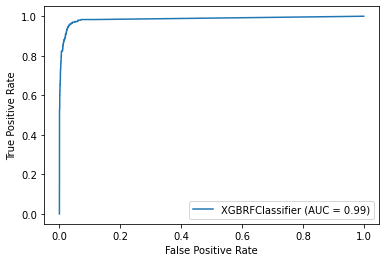

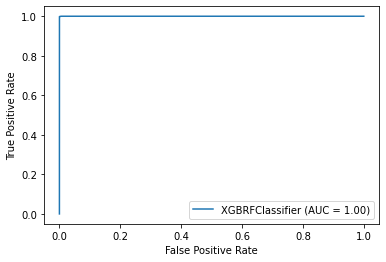

In [30]:
# modeling:

model_xgb_rf_2 = xgb.XGBRFClassifier(random_state = 42, n_estimator = 400, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 40, bootstrap = False, scale_pos_weight = data['class'].value_counts()[0]/data['class'].value_counts()[1])
model_xgb_rf_2.fit(train_dummies_xgb.drop(['class'], axis = 1), train_dummies_xgb['class'])
plot_roc_curve(model_xgb_rf_2, test_dummies_xgb.drop(['class'], axis = 1), test_dummies_xgb['class']), plot_roc_curve(model_xgb_rf_2, train_dummies_xgb.drop(['class'], axis = 1), train_dummies_xgb['class'])

In [31]:
pred_xgb_rf_2 = model_xgb_rf_2.predict(test_dummies_xgb.drop(['class'], axis = 1))
pred_xgb_prob_rf_2 = model_xgb_rf_2.predict_proba(test_dummies_xgb.drop(['class'], axis = 1))

print(f"accuracy score: {accuracy_score(test_dummies_xgb['class'], pred_xgb_rf_2)}")
print(f"precision score: {precision_score(test_dummies_xgb['class'], pred_xgb_rf_2)}, recall score: {recall_score(test_dummies_xgb['class'], pred_xgb_rf_2)}")
print(confusion_matrix(test_dummies_xgb['class'], pred_xgb_rf_2))

accuracy score: 0.9918333333333333
precision score: 0.7865168539325843, recall score: 0.7
[[17643    57]
 [   90   210]]


# train the model with best hyperparameters on actual test data:
## XGBoost:

In [28]:
test_data = pd.read_csv('/Users/belleshen/Documents/VS_Code/Project/AirPressureSystemFailureDetection/Data/archive/aps_failure_test_set.csv')

# replace 'na' with -1
test_data = test_data.applymap(lambda x: -1 if x == 'na' else x)

# replace target feature with numerical numbers:
test_data['class'] = test_data['class'].map(lambda x: 1 if x == 'pos' else 0)

# turn all the features into numerical in order to get correlation coefficient
for i in test_data.columns:
    test_data[i] = pd.to_numeric(test_data[i])

# feature engineering:

test_data['aq_000 + ag_003'] = test_data.apply(lambda x: x['aq_000'] + x['ag_003'] ,axis = 1)
test_data['ci_000 + cj_000'] = test_data.apply(lambda x: x['ci_000'] + x['cj_000'] ,axis = 1)

test_data.drop(['aq_000', 'ag_003', 'ci_000', 'cj_000'], axis = 1, inplace = True)

# one hot encoding:

test_data_dummies_xgb = pd.get_dummies(test_data, columns = cat_cols)

test_data_dummies_xgb = test_data_dummies_xgb.reindex(columns = train_dummies_xgb.columns, fill_value = 0)
test_data_dummies_xgb = test_data_dummies_xgb[train_dummies_xgb.columns]

# modeling:

test_prediction_xgb_2 = model_xgb_4.predict(test_data_dummies_xgb.drop(['class'], axis = 1))
test_prediction_prob_xgb_2 = model_xgb_4.predict_proba(test_data_dummies_xgb.drop(['class'], axis = 1))

print(f"accuracy score: {accuracy_score(test_data_dummies_xgb['class'], test_prediction_xgb_2)}")
print(f"precision score: {precision_score(test_data_dummies_xgb['class'], test_prediction_xgb_2)}, recall score: {recall_score(test_data_dummies_xgb['class'], test_prediction_xgb_2)}")
print(confusion_matrix(test_data_dummies_xgb['class'], test_prediction_xgb_2))

accuracy score: 0.9925625
precision score: 0.8595505617977528, recall score: 0.816
[[15575    50]
 [   69   306]]


# train the model with best hyperparameters on actual test data:
## Logistic:

In [29]:
test_data = pd.read_csv('/Users/belleshen/Documents/VS_Code/Project/AirPressureSystemFailureDetection/Data/archive/aps_failure_test_set.csv')

# replace 'na' with -1
test_data = test_data.applymap(lambda x: -1 if x == 'na' else x)

# replace target feature with numerical numbers:
test_data['class'] = test_data['class'].map(lambda x: 1 if x == 'pos' else 0)

# turn all the features into numerical in order to get correlation coefficient
for i in test_data.columns:
    test_data[i] = pd.to_numeric(test_data[i])

# feature engineering:

test_data['aq_000 + ag_003'] = test_data.apply(lambda x: x['aq_000'] + x['ag_003'] ,axis = 1)
test_data['ci_000 + cj_000'] = test_data.apply(lambda x: x['ci_000'] + x['cj_000'] ,axis = 1)

test_data.drop(['aq_000', 'ag_003', 'ci_000', 'cj_000'], axis = 1, inplace = True)

# scaling:

test_data_scaled_df = pd.DataFrame(scaler.transform(test_data[candidate_cols_new_2]), columns = candidate_cols_new_2, index = test_data.index)

# one hot encoding:

test_data_dummies = pd.get_dummies(test_data, columns = cat_cols)
test_data_dummies.drop(candidate_cols_new_2, axis = 1, inplace = True)

test_data_dummies = test_data_dummies.reindex(columns = train_dummies.columns, fill_value = 0)
test_data_dummies = test_data_dummies[train_dummies.columns]

# merge scaled df & dummies:

test_data_combined = test_data_scaled_df.merge(test_data_dummies, how = 'left', left_index = True, right_index = True)

# modeling:

test_prediction_1 = model_1.predict(test_data_combined.drop(['class'], axis = 1))
test_prediction_prob_1 = model_1.predict_proba(test_data_combined.drop(['class'], axis = 1))

print(f"accuracy score: {accuracy_score(test_data_combined['class'], test_prediction_1)}")
print(f"precision score: {precision_score(test_data_combined['class'], test_prediction_1)}, recall score: {recall_score(test_data_combined['class'], test_prediction_1)}")
print(confusion_matrix(test_data_combined['class'], test_prediction_1))

accuracy score: 0.97275
precision score: 0.4596026490066225, recall score: 0.9253333333333333
[[15217   408]
 [   28   347]]


In [109]:
test_data_combined.to_csv('test_data_combined_res_logistic.csv', index = False)

# train the model with best hyperparameters on actual test data:
## XGBoost_RF:

In [32]:
test_prediction_xgb_rf_2 = model_xgb_rf_2.predict(test_data_dummies_xgb.drop(['class'], axis = 1))
test_prediction_prob_xgb_rf_2 = model_xgb_rf_2.predict_proba(test_data_dummies_xgb.drop(['class'], axis = 1))

print(f"accuracy score: {accuracy_score(test_data_dummies_xgb['class'], test_prediction_xgb_rf_2)}")
print(f"precision score: {precision_score(test_data_dummies_xgb['class'], test_prediction_xgb_rf_2)}, recall score: {recall_score(test_data_dummies_xgb['class'], test_prediction_xgb_rf_2)}")
print(confusion_matrix(test_data_dummies_xgb['class'], test_prediction_xgb_rf_2))

accuracy score: 0.9900625
precision score: 0.8552631578947368, recall score: 0.6933333333333334
[[15581    44]
 [  115   260]]


# Ensemble 3 models with hyper parameters tuning for actual test data:

In [33]:
logistc_pred_test_1 = pd.DataFrame(test_prediction_prob_1, columns = ['Logistic_pred_0', 'Logistic_pred_1'], index = test_data_combined.index)
logistc_pred_test_1

,Logistic_pred_0,Logistic_pred_1
0,0.962873,0.037127
1,0.962166,0.037834
2,0.954537,0.045463
3,0.939844,0.060156
4,0.959667,0.040333
...,...,...
15995,0.916281,0.083719
15996,0.962185,0.037815
15997,0.888202,0.111798
15998,0.962028,0.037972


In [34]:
xgb_pred_test_2 = pd.DataFrame(test_prediction_prob_xgb_2, columns = ['xgb_pred_0', 'xgb_pred_1'], index = test_data_dummies_xgb.index)
xgb_pred_test_2 

,xgb_pred_0,xgb_pred_1
0,0.999996,3.904903e-06
1,0.999999,9.670688e-07
2,0.999988,1.202346e-05
3,1.000000,2.855508e-07
4,0.999997,2.836091e-06
...,...,...
15995,1.000000,3.733950e-07
15996,0.999999,1.301467e-06
15997,0.999999,5.410037e-07
15998,0.997587,2.413417e-03


In [35]:
xgb_rf_pred_test_2 = pd.DataFrame(test_prediction_prob_xgb_rf_2, columns = ['xgb_rf_pred_0', 'xgb_rf_pred_1'], index = test_data_dummies_xgb.index)
xgb_rf_pred_test_2 

,xgb_rf_pred_0,xgb_rf_pred_1
0,0.880797,0.119203
1,0.880797,0.119203
2,0.880797,0.119203
3,0.880797,0.119203
4,0.880797,0.119203
...,...,...
15995,0.880797,0.119203
15996,0.880797,0.119203
15997,0.880797,0.119203
15998,0.880797,0.119203


In [36]:
test_data_prediction_df = logistc_pred_test_1.merge(xgb_pred_test_2, how = 'left', left_index = True, right_index = True).merge(xgb_rf_pred_test_2, how = 'left', left_index = True, right_index = True)
test_data_prediction_df

,Logistic_pred_0,Logistic_pred_1,xgb_pred_0,xgb_pred_1,xgb_rf_pred_0,xgb_rf_pred_1
0,0.962873,0.037127,0.999996,3.904903e-06,0.880797,0.119203
1,0.962166,0.037834,0.999999,9.670688e-07,0.880797,0.119203
2,0.954537,0.045463,0.999988,1.202346e-05,0.880797,0.119203
3,0.939844,0.060156,1.000000,2.855508e-07,0.880797,0.119203
4,0.959667,0.040333,0.999997,2.836091e-06,0.880797,0.119203
...,...,...,...,...,...,...
15995,0.916281,0.083719,1.000000,3.733950e-07,0.880797,0.119203
15996,0.962185,0.037815,0.999999,1.301467e-06,0.880797,0.119203
15997,0.888202,0.111798,0.999999,5.410037e-07,0.880797,0.119203
15998,0.962028,0.037972,0.997587,2.413417e-03,0.880797,0.119203


In [39]:
test_data_prediction_df['ensemble_pred_1'] = test_data_prediction_df.apply(lambda x: (x['xgb_pred_1'] * .5) + (x['xgb_rf_pred_1'] * .25) + (x['Logistic_pred_1'] * .25), axis = 1)
test_data_prediction_df

,Logistic_pred_0,Logistic_pred_1,xgb_pred_0,xgb_pred_1,xgb_rf_pred_0,xgb_rf_pred_1,ensemble_pred_1
0,0.962873,0.037127,0.999996,3.904903e-06,0.880797,0.119203,0.039085
1,0.962166,0.037834,0.999999,9.670688e-07,0.880797,0.119203,0.039260
2,0.954537,0.045463,0.999988,1.202346e-05,0.880797,0.119203,0.041173
3,0.939844,0.060156,1.000000,2.855508e-07,0.880797,0.119203,0.044840
4,0.959667,0.040333,0.999997,2.836091e-06,0.880797,0.119203,0.039886
...,...,...,...,...,...,...,...
15995,0.916281,0.083719,1.000000,3.733950e-07,0.880797,0.119203,0.050731
15996,0.962185,0.037815,0.999999,1.301467e-06,0.880797,0.119203,0.039255
15997,0.888202,0.111798,0.999999,5.410037e-07,0.880797,0.119203,0.057751
15998,0.962028,0.037972,0.997587,2.413417e-03,0.880797,0.119203,0.040500


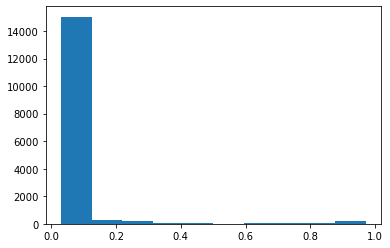

In [40]:
plt.hist(test_data_prediction_df['ensemble_pred_1']);

In [51]:
test_data_prediction_df['ensemble_pred_binary_1'] = test_data_prediction_df['ensemble_pred_1'].map(lambda x: 1 if x > .8 else 0)
test_data_prediction_df

,Logistic_pred_0,Logistic_pred_1,xgb_pred_0,xgb_pred_1,xgb_rf_pred_0,xgb_rf_pred_1,ensemble_pred_1,ensemble_pred_binary_1
0,0.962873,0.037127,0.999996,3.904903e-06,0.880797,0.119203,0.039085,0
1,0.962166,0.037834,0.999999,9.670688e-07,0.880797,0.119203,0.039260,0
2,0.954537,0.045463,0.999988,1.202346e-05,0.880797,0.119203,0.041173,0
3,0.939844,0.060156,1.000000,2.855508e-07,0.880797,0.119203,0.044840,0
4,0.959667,0.040333,0.999997,2.836091e-06,0.880797,0.119203,0.039886,0
...,...,...,...,...,...,...,...,...
15995,0.916281,0.083719,1.000000,3.733950e-07,0.880797,0.119203,0.050731,0
15996,0.962185,0.037815,0.999999,1.301467e-06,0.880797,0.119203,0.039255,0
15997,0.888202,0.111798,0.999999,5.410037e-07,0.880797,0.119203,0.057751,0
15998,0.962028,0.037972,0.997587,2.413417e-03,0.880797,0.119203,0.040500,0


In [52]:
print(f"accuracy score: {accuracy_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )}")
print(f"precision score: {precision_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )}, recall score: {recall_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )}")
print(confusion_matrix(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1']))

accuracy score: 0.992
precision score: 0.9273356401384083, recall score: 0.7146666666666667
[[15604    21]
 [  107   268]]


In [53]:
precision_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )

0.9273356401384083

In [56]:
for i in np.linspace(0.6, 1, num = 10 , endpoint=False):
    test_data_prediction_df['ensemble_pred_binary_1'] = test_data_prediction_df['ensemble_pred_1'].map(lambda x: 1 if x > i else 0)
    print(f"threshold = {i}")
    print(f"accuracy score: {accuracy_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )}")
    print(f"precision score: {precision_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )}, recall score: {recall_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )}")
    print(confusion_matrix(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1']))
    print("===============================================")
    

threshold = 0.6
accuracy score: 0.992875
precision score: 0.865546218487395, recall score: 0.824
[[15577    48]
 [   66   309]]
threshold = 0.64
accuracy score: 0.9925
precision score: 0.8717201166180758, recall score: 0.7973333333333333
[[15581    44]
 [   76   299]]
threshold = 0.6799999999999999
accuracy score: 0.992375
precision score: 0.8798798798798799, recall score: 0.7813333333333333
[[15585    40]
 [   82   293]]
threshold = 0.72
accuracy score: 0.9923125
precision score: 0.8818181818181818, recall score: 0.776
[[15586    39]
 [   84   291]]
threshold = 0.76
accuracy score: 0.992375
precision score: 0.9067524115755627, recall score: 0.752
[[15596    29]
 [   93   282]]
threshold = 0.8
accuracy score: 0.992
precision score: 0.9273356401384083, recall score: 0.7146666666666667
[[15604    21]
 [  107   268]]
threshold = 0.84
accuracy score: 0.991375
precision score: 0.9471698113207547, recall score: 0.6693333333333333
[[15611    14]
 [  124   251]]
threshold = 0.88
accuracy score

In [57]:
precision_score_box = []
recall_score_box = []

for i in np.linspace(0.6, 1, num = 10 , endpoint=False):
    test_data_prediction_df['ensemble_pred_binary_1'] = test_data_prediction_df['ensemble_pred_1'].map(lambda x: 1 if x > i else 0)
    precision = precision_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )
    recall    = recall_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )
    precision_score_box.append(precision)
    recall_score_box.append(recall)

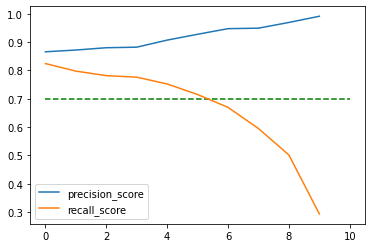

In [77]:
plt.plot(precision_score_box, label = 'precision_score')
plt.plot(recall_score_box, label = 'recall_score')
plt.hlines(y = 0.7, xmin = 0, xmax = 10, colors = 'green', linestyles = '--')
plt.legend()

In [67]:
np.linspace(0.75, 1, num = 25 , endpoint=False)

array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
       0.97, 0.98, 0.99])

In [80]:
precision_score_box_1 = []
recall_score_box_1 = []

for i in np.linspace(0.75, 1, num = 25 , endpoint=False):
    test_data_prediction_df['ensemble_pred_binary_1'] = test_data_prediction_df['ensemble_pred_1'].map(lambda x: 1 if x > i else 0)
    precision = precision_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )
    recall    = recall_score(test_data['class'], test_data_prediction_df['ensemble_pred_binary_1'] )
    precision_score_box_1.append(precision)
    recall_score_box_1.append(recall)

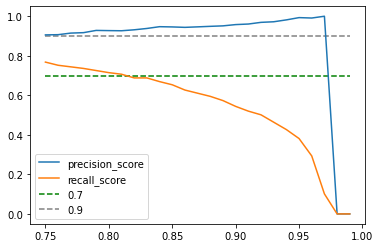

In [87]:
plt.plot(np.linspace(0.75, 1, num = 25 , endpoint=False), precision_score_box_1, label = 'precision_score')
plt.plot(np.linspace(0.75, 1, num = 25 , endpoint=False), recall_score_box_1, label = 'recall_score')
plt.hlines(y = 0.7, xmin = 0.75, xmax = 0.99, colors = 'green', linestyles = '--', label = '0.7')
plt.hlines(y = 0.9, xmin = 0.75, xmax = 0.99, colors = 'grey', linestyles = '--', label = '0.9')
plt.legend()

# conclusion: set threshold = 0.8

# Stack:

In [88]:
test_data_prediction_df

,Logistic_pred_0,Logistic_pred_1,xgb_pred_0,xgb_pred_1,xgb_rf_pred_0,xgb_rf_pred_1,ensemble_pred_1,ensemble_pred_binary_1
0,0.962873,0.037127,0.999996,3.904903e-06,0.880797,0.119203,0.039085,0
1,0.962166,0.037834,0.999999,9.670688e-07,0.880797,0.119203,0.039260,0
2,0.954537,0.045463,0.999988,1.202346e-05,0.880797,0.119203,0.041173,0
3,0.939844,0.060156,1.000000,2.855508e-07,0.880797,0.119203,0.044840,0
4,0.959667,0.040333,0.999997,2.836091e-06,0.880797,0.119203,0.039886,0
...,...,...,...,...,...,...,...,...
15995,0.916281,0.083719,1.000000,3.733950e-07,0.880797,0.119203,0.050731,0
15996,0.962185,0.037815,0.999999,1.301467e-06,0.880797,0.119203,0.039255,0
15997,0.888202,0.111798,0.999999,5.410037e-07,0.880797,0.119203,0.057751,0
15998,0.962028,0.037972,0.997587,2.413417e-03,0.880797,0.119203,0.040500,0


In [89]:
stack_df = test_data_prediction_df[['Logistic_pred_1', 'xgb_pred_1', 'xgb_rf_pred_1']]
stack_df

,Logistic_pred_1,xgb_pred_1,xgb_rf_pred_1
0,0.037127,3.904903e-06,0.119203
1,0.037834,9.670688e-07,0.119203
2,0.045463,1.202346e-05,0.119203
3,0.060156,2.855508e-07,0.119203
4,0.040333,2.836091e-06,0.119203
...,...,...,...
15995,0.083719,3.733950e-07,0.119203
15996,0.037815,1.301467e-06,0.119203
15997,0.111798,5.410037e-07,0.119203
15998,0.037972,2.413417e-03,0.119203


In [91]:
stack_df = stack_df.merge(test_data['class'], how = 'left', left_index = True, right_index = True)
stack_df 

,Logistic_pred_1,xgb_pred_1,xgb_rf_pred_1,class
0,0.037127,3.904903e-06,0.119203,0
1,0.037834,9.670688e-07,0.119203,0
2,0.045463,1.202346e-05,0.119203,0
3,0.060156,2.855508e-07,0.119203,0
4,0.040333,2.836091e-06,0.119203,0
...,...,...,...,...
15995,0.083719,3.733950e-07,0.119203,0
15996,0.037815,1.301467e-06,0.119203,0
15997,0.111798,5.410037e-07,0.119203,0
15998,0.037972,2.413417e-03,0.119203,0


In [92]:
stack_model_1 = LogisticRegression().fit(stack_df.drop(['class'], axis = 1), stack_df['class'])

In [93]:
stack_prediction_prob = stack_model_1.predict_proba(stack_df.drop(['class'], axis = 1))
stack_pred_df = pd.DataFrame(stack_prediction_prob, columns=['stack_prob_0', 'stack_prob_1'], index = stack_df.index)
stack_pred_df

,stack_prob_0,stack_prob_1
0,0.998510,0.001490
1,0.998506,0.001494
2,0.998458,0.001542
3,0.998361,0.001639
4,0.998490,0.001510
...,...,...
15995,0.998192,0.001808
15996,0.998506,0.001494
15997,0.997969,0.002031
15998,0.998493,0.001507


In [94]:
stack_pred_df_1 = stack_df.merge(stack_pred_df, how = 'left', right_index = True, left_index = True)
stack_pred_df_1 

,Logistic_pred_1,xgb_pred_1,xgb_rf_pred_1,class,stack_prob_0,stack_prob_1
0,0.037127,3.904903e-06,0.119203,0,0.998510,0.001490
1,0.037834,9.670688e-07,0.119203,0,0.998506,0.001494
2,0.045463,1.202346e-05,0.119203,0,0.998458,0.001542
3,0.060156,2.855508e-07,0.119203,0,0.998361,0.001639
4,0.040333,2.836091e-06,0.119203,0,0.998490,0.001510
...,...,...,...,...,...,...
15995,0.083719,3.733950e-07,0.119203,0,0.998192,0.001808
15996,0.037815,1.301467e-06,0.119203,0,0.998506,0.001494
15997,0.111798,5.410037e-07,0.119203,0,0.997969,0.002031
15998,0.037972,2.413417e-03,0.119203,0,0.998493,0.001507


(array([1.5532e+04, 6.2000e+01, 2.6000e+01, 1.7000e+01, 1.0000e+01,
        1.6000e+01, 1.8000e+01, 2.4000e+01, 4.0000e+01, 2.5500e+02]),
 array([0.00130786, 0.09703103, 0.1927542 , 0.28847737, 0.38420054,
        0.47992371, 0.57564688, 0.67137005, 0.76709322, 0.86281639,
        0.95853956]),
 <BarContainer object of 10 artists>)

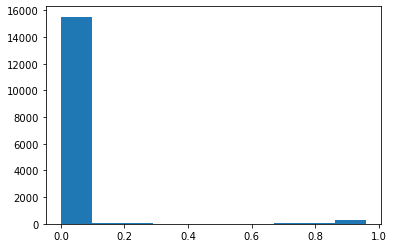

In [95]:
plt.hist(stack_pred_df_1 ['stack_prob_1'])

In [104]:
stack_pred_df_1['stack_pred_binary_1'] = stack_pred_df_1['stack_prob_1'].map(lambda x: 1 if x > .78 else 0)
stack_pred_df_1

,Logistic_pred_1,xgb_pred_1,xgb_rf_pred_1,class,stack_prob_0,stack_prob_1,stack_pred_binary_1
0,0.037127,3.904903e-06,0.119203,0,0.998510,0.001490,0
1,0.037834,9.670688e-07,0.119203,0,0.998506,0.001494,0
2,0.045463,1.202346e-05,0.119203,0,0.998458,0.001542,0
3,0.060156,2.855508e-07,0.119203,0,0.998361,0.001639,0
4,0.040333,2.836091e-06,0.119203,0,0.998490,0.001510,0
...,...,...,...,...,...,...,...
15995,0.083719,3.733950e-07,0.119203,0,0.998192,0.001808,0
15996,0.037815,1.301467e-06,0.119203,0,0.998506,0.001494,0
15997,0.111798,5.410037e-07,0.119203,0,0.997969,0.002031,0
15998,0.037972,2.413417e-03,0.119203,0,0.998493,0.001507,0


In [105]:
print(f"accuracy score: {accuracy_score(stack_pred_df_1['class'], stack_pred_df_1['stack_pred_binary_1'] )}")
print(f"precision score: {precision_score(stack_pred_df_1['class'], stack_pred_df_1['stack_pred_binary_1'] )}, recall score: {recall_score(stack_pred_df_1['class'], stack_pred_df_1['stack_pred_binary_1'] )}")
print(confusion_matrix(stack_pred_df_1['class'], stack_pred_df_1['stack_pred_binary_1']))

accuracy score: 0.9920625
precision score: 0.9217687074829932, recall score: 0.7226666666666667
[[15602    23]
 [  104   271]]


In [98]:
precision_score_box_stack = []
recall_score_box_stack = []

for i in np.linspace(0.6, 1, num = 10 , endpoint=False):
    stack_pred_df_1['stack_pred_binary_1'] = stack_pred_df_1['stack_prob_1'].map(lambda x: 1 if x > i else 0)
    precision = precision_score(stack_pred_df_1['class'], stack_pred_df_1['stack_pred_binary_1'] )
    recall    = recall_score(stack_pred_df_1['class'], stack_pred_df_1['stack_pred_binary_1'] )
    precision_score_box_stack.append(precision)
    recall_score_box_stack.append(recall)

/Users/belleshen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


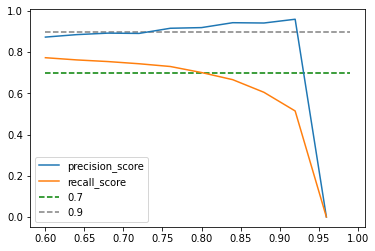

In [102]:
plt.plot(np.linspace(0.6, 1, num = 10 , endpoint=False), precision_score_box_stack, label = 'precision_score')
plt.plot(np.linspace(0.6, 1, num = 10 , endpoint=False), recall_score_box_stack, label = 'recall_score')
plt.hlines(y = 0.7, xmin = 0.6, xmax = 0.99, colors = 'green', linestyles = '--', label = '0.7')
plt.hlines(y = 0.9, xmin = 0.6, xmax = 0.99, colors = 'grey', linestyles = '--', label = '0.9')
plt.legend()